# [WHAT IS TORCH.NN REALLY?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

## MNIST data setup

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("~/data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


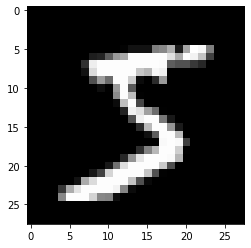

In [5]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

 convert our data.

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

In [7]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x: torch.Tensor) -> torch.Tensor:
#     print(x.size())
#     print(x.sum(-1).size())  # sumの引数は、-iでn-i+1次元目について和を取るということ？
#     print(x.sum(-2).size())

#     print(x.exp().sum(-1).log().size())
#     print(x.exp().sum(-1).log().unsqueeze(-1).size())  # unsqueeze(-1)の度に[64]が[64, 1], [64, 1, 1]...
#     print(x.exp().sum(-1).log().unsqueeze(-2).size())  # unsqueeze(-2)だと[1, 64]のようになる  
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb: torch.Tensor) -> torch.Tensor:
#     print(torch.matmul(xb, weights).size())
#     print((xb@weights).size())
    return log_softmax(xb @ weights + bias)  # @は行列の掛け算

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

def nll(input, target):  # negative log likelihood
    return -input[range(target.shape[0]), target].mean()

loss_func = nll
yb = y_train[0:bs]
print(loss_func(preds, yb))

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor([-1.5055, -2.2933, -2.2723, -2.7748, -2.6441, -2.5866, -2.1868, -2.5084,
        -2.4798, -2.4310], grad_fn=<SelectBackward>) torch.Size([64, 10])
tensor(2.3295, grad_fn=<NegBackward>)
tensor(0.0781)


We can now run a training loop. For each iteration, we will:

select a mini-batch of data (of size bs)
use the model to make predictions
calculate the loss
loss.backward() updates the gradients of the model, in this case, weights and bias.
We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient.

We then **set the gradients to zero**, so that we are ready for the next loop. 

In [8]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [9]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

In [10]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb: torch.Tensor) -> torch.Tensor:  # 上書きした？
    return xb @ weights + bias
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module
In this case, we want to create a class that holds our weights, bias, and method for the forward step. 
`nn.Module` has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.
（モデルを作る。）

In [14]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3133, grad_fn=<NllLossBackward>)


重みやバイアスの更新を
```
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```
としていたが、以下のようにできるように。

```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

↓fit()関数内にまとめる。

In [20]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()
print(loss_func(model(xb), yb))

tensor(0.0656, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear
`self.weights` や `self.bias`を用い、forwardを`xb  @ self.weights + self.bias`と記述していたのをリファクタリング

In [23]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))
fit()  # fit()への変更なし

print(loss_func(model(xb), yb))

tensor(2.2854, grad_fn=<NllLossBackward>)
tensor(0.0820, grad_fn=<NllLossBackward>)


## Refactor using optim
```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```
としてたのを
```
opt.step()
opt.zero_grad()
```
と記述できる.optは最適化の方法（adamとかSGDとか）.

In [25]:
from torch import optim
def get_model():  # modelとoptimを返す
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()  # for p in model.parameters(): p -= p.grad * lrに相当？
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3794, grad_fn=<NllLossBackward>)
tensor(0.0813, grad_fn=<NllLossBackward>)


## Refactor using Dataset
DATA LOADING AND PROCESSING TUTORIALの`FacialLandmarkDataset`（`Dataset`の子クラス）を見ていく。

In [26]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)  # 訓練用データセットをひとまとめに              

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]     # バッチ生成
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0818, grad_fn=<NllLossBackward>)


## Refactor using DataLoader
バッチ生成時に`train_ds[i*bs : i*bs+bs]`としてたのを、`DataLoader(train_ds, batch_size=bs)`と記述できる

In [29]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


## Add validation
実用上、validation setは、逐一training setをシャッフルして生成する必要がある。(overfitting抑制)

In [30]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.4592)
1 tensor(0.2931)


## Create fit() and get_data()

fit()で学習

In [31]:
import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3101168833255768
1 0.29984347305297854


## Switch to CNN

In [33]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)  # view is PyTorch’s version of numpy’s reshape
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1
model = Mnist_CNN()

# Momentum is a variation on stochastic gradient descent 
# that takes previous updates into account as well and generally leads to faster training.
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.42040517716407777
1 0.22890574584007264


## nn.Sequential
モデル定義の別の方法

In [34]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3190848581314087
1 0.24957599420547485


## Wrapping DataLoader
Our CNN is fairly concise, but it **only works with MNIST**, because:
* It assumes the input is a 28*28 long vector
* It assumes that the final CNN grid size is 4*4 (since that’s the average
pooling kernel size we used)

**Let’s get rid of these two assumptions**, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:



In [36]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace `nn.AvgPool2d` with `nn.AdaptiveAvgPool2d`, which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [38]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.46218811750411987
1 0.27339917345047


## Using your GPU

In [39]:
USE_CUDA = torch.cuda.is_available()
dev = torch.device(
    "cuda") if USE_CUDA else torch.device("cpu")

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.22811423587799073
1 0.1917944995880127


## [まとめ](https://pytorch.org/tutorials/beginner/nn_tutorial.html#closing-thoughts)

We now have a general data pipeline and training loop which you can use for training many types of models using Pytorch. To see how simple training a model can now be, take a look at the mnist_sample sample notebook.

Of course, there are many things you’ll want to add, such as data augmentation, hyperparameter tuning, monitoring training, transfer learning, and so forth. These features are available in the fastai library, which has been developed using the same design approach shown in this tutorial, providing a natural next step for practitioners looking to take their models further.

We promised at the start of this tutorial we’d explain through example each of torch.nn, torch.optim, Dataset, and DataLoader. So let’s summarize what we’ve seen:

torch.nn
Module: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). It knows what Parameter (s) it contains and can zero all their gradients, loop through them for weight updates, etc.
Parameter: a wrapper for a tensor that tells a Module that it has weights that need updating during backprop. Only tensors with the requires_grad attribute set are updated
functional: a module(usually imported into the F namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.
torch.optim: Contains optimizers such as SGD, which update the weights of Parameter during the backward step
Dataset: An abstract interface of objects with a __len__ and a __getitem__, including classes provided with Pytorch such as TensorDataset
DataLoader: Takes any Dataset and creates an iterator which returns batches of data.
